# Notebook for Modeling Beat Data Using an Autoencoder 

## Setup

In [2]:
%load_ext autoreload
%autoreload 2
    
import os
import numpy as np
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import json
import sys
sys.path.append("../")
from scripts.utils import get_project_path
from scripts.plotting import plot_recon_error_dist, plot_PR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train Autoencoder via CLI

In [3]:
output_dir = get_project_path("models","autoencoder")
os.makedirs(output_dir, exist_ok = True)

train_script = get_project_path("scripts", "train_autoencoder.py")
segments_path = get_project_path("data", "processed", "beat_segments.npy")
labels_path = get_project_path("data", "processed", "beats_dataset.csv")

import subprocess

subprocess.run([
    "python", train_script,
    "--segments-path", segments_path,
    "--labels-path", labels_path,
    "--output-dir", output_dir
])

print(f"python {train_script} --segments-path {segments_path} --labels-path {labels_path} --output-dir {output_dir}")

python C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\scripts\train_autoencoder.py --segments-path C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data\processed\beat_segments.npy --labels-path C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data\processed\beats_dataset.csv --output-dir C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\models\autoencoder


## Load Data and Model

In [4]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

model = load_model(os.path.join(output_dir, "autoencoder_model.h5"))
mean = np.load(os.path.join(output_dir, "scaler_mean.npy"))
scale = np.load(os.path.join(output_dir, "scaler_scale.npy"))

scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

segments = np.load(segments_path)
labels_df = pd.read_csv(labels_path)
X_all = segments.reshape(segments.shape[0], -1)
X_scaled = scaler.transform(X_all)

## Reconstruction Error

In [5]:
preds = model.predict(X_scaled)
recon_error = np.mean((X_scaled - preds) ** 2, axis = 1)

336/336 [==============================] - 1s 2ms/step


## Label Evaluation

In [6]:
labels_df["category"] = labels_df["label"].apply(lambda x: "Normal" if x == "N" else "Abnormal")
y_true = (labels_df["category"] == "Abnormal").astype(int)

## Evaluation Metrics

In [7]:
roc_auc = roc_auc_score(y_true, recon_error)
prec, recall, thresholds = precision_recall_curve(y_true, recon_error)
pr_auc = auc(recall, prec)

## Optimize Thresholds for Best F1 Score

In [8]:
f1_scores = [f1_score(y_true, recon_error >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

In [9]:
print(f"ROC_AUC: {roc_auc: .3f}")
print(f"PR AUC: {pr_auc: .3f}")
print(f"Best Threshold: {best_thresh: .6f}")
print(f"Best F1 Score: {best_f1: .3f}")

ROC_AUC:  0.995
PR AUC:  0.992
Best Threshold:  0.138756
Best F1 Score:  0.961


## Visualizations

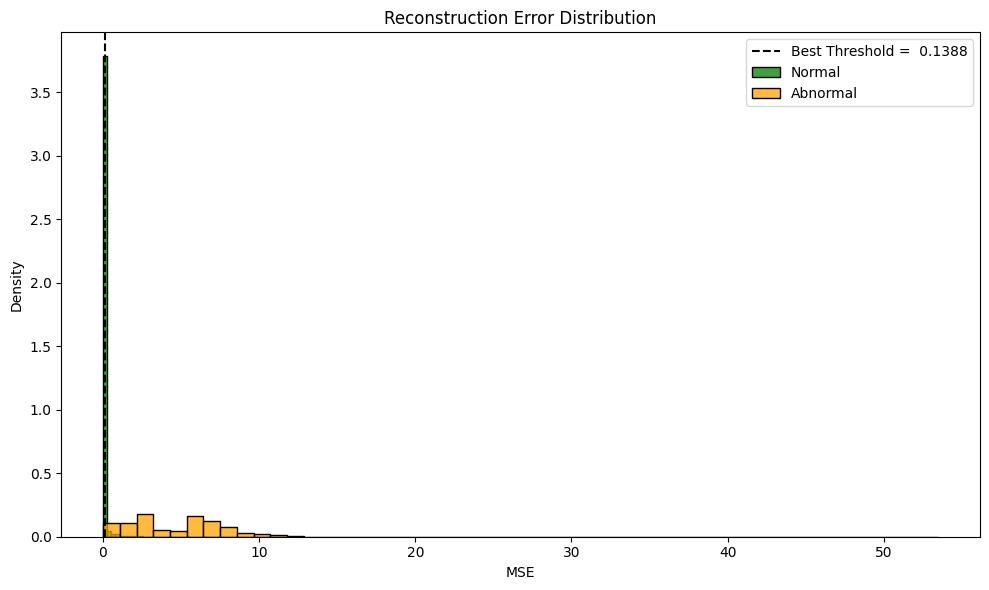

In [10]:
plot_recon_error_dist(recon_error, y_true, best_thresh)

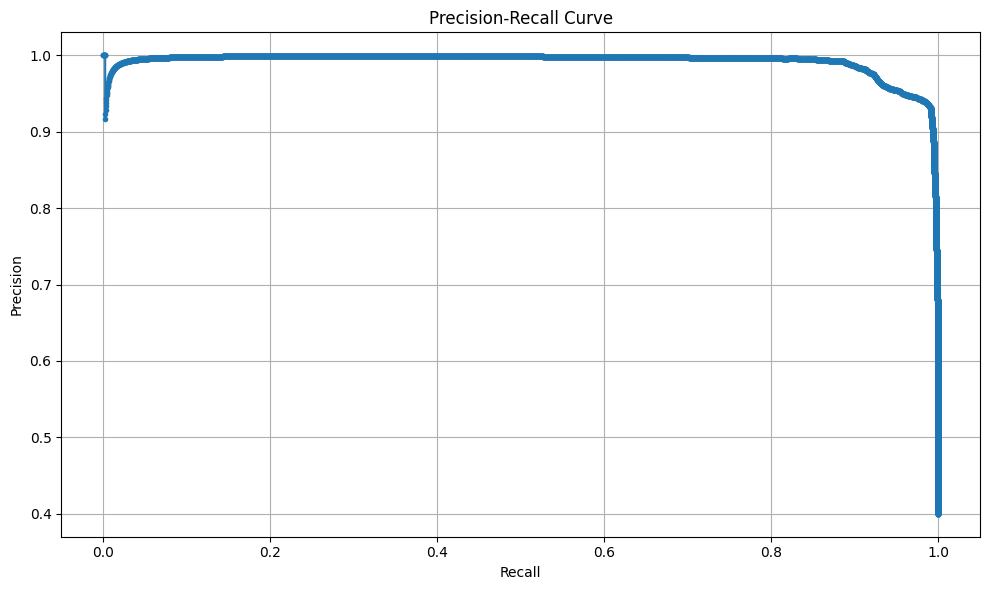

In [11]:
plot_PR(prec, recall)

## Save Metrics for Dashboad Comparison Notebook

In [13]:
np.save(os.path.join(output_dir, "y_true.npy"), y_true)
np.save(os.path.join(output_dir, "recon_error.npy"), recon_error)

# Save Metrics
metrics = {
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "best_f1": float(best_f1),
    "best_thresh": float(best_thresh)
}

with open(os.path.join(output_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent = 2)

print(f"Saved evaluation outputs to: {output_dir}")

Saved evaluation outputs to: C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\models\autoencoder
